# AED Taper Analysis (Using AD Ratios)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, pickle
from numpy import hanning
from scipy.fftpack import fft
from scipy.signal import iirnotch, filtfilt
from ieeg_utils import *

TABLES_DIRECTORY = "../../Data/giant_tables"
IEEG_DIRECTORY = "../../Data/ieeg/all/2_min"
OUTPUT_DIRECTORY = "../../Data/aed_taper_criticality/gamma_normalization_960_lags"

TAPER_THRESHOLD = 0.9

In [2]:
patient_hup_ids = []
# Iterate through all files in TABLES_DIRECTORY
for filename in os.listdir(TABLES_DIRECTORY):
    # Only look at filename that are .csv files and does not begin with .
    if filename.endswith(".csv") and not filename.startswith("."):
        # Get the patient_hup_id from the filename which is after _ and before .
        patient_hup_id = str(filename.split("_")[1].split(".")[0])
        patient_hup_ids.append(patient_hup_id)

patient_hup_ids = [210]
patient_hup_ids = sorted(patient_hup_ids)
len(patient_hup_ids)

1

In [3]:
# Create an empty dictionary to store all the data
data_dict = {"dataset_name": [], "max_hour": [], "sample_rate": [], "hup_id": []}

# Iterate through the directory
for filename in os.listdir(IEEG_DIRECTORY):
    if filename.endswith(".pkl"):  # Only process .pkl files
        # Split the filename to get the dataset_name, hour, and sample_rate
        parts = filename.split("_")
        dataset_name = "_".join(parts[:-4])  # Exclude the '_hr' from the dataset_name
        hour = int(parts[-3])
        sample_rate = int(parts[-1].split(".")[0])

        # Extract hup_id from dataset_name
        hup_id = dataset_name.split("_")[0].split("HUP")[1]

        # If the dataset_name is already in the dictionary, update the max_hour
        if dataset_name in data_dict["dataset_name"]:
            index = data_dict["dataset_name"].index(dataset_name)
            data_dict["max_hour"][index] = max(data_dict["max_hour"][index], hour)
        else:
            # Else, add the dataset_name, hour, sample_rate and hup_id to the dictionary
            data_dict["dataset_name"].append(dataset_name)
            data_dict["max_hour"].append(hour)
            data_dict["sample_rate"].append(sample_rate)
            data_dict["hup_id"].append(hup_id)

# Create a DataFrame from the dictionary
datasets_df = pd.DataFrame(data_dict)
# Make max_hour and sample_rate and hup_id integers
datasets_df["max_hour"] = datasets_df["max_hour"].astype(int)
datasets_df["sample_rate"] = datasets_df["sample_rate"].astype(int)
datasets_df["hup_id"] = datasets_df["hup_id"].astype(int)
# Sort by hup_id
datasets_df = datasets_df.sort_values(by=["hup_id"])
# Reset the index
datasets_df = datasets_df.reset_index(drop=True)
# Create a column called max_hour_count that is the max_hour + 1
datasets_df["max_hour_count"] = datasets_df["max_hour"] + 1
datasets_df

,dataset_name,max_hour,sample_rate,hup_id,max_hour_count
0,HUP138_phaseII,172,1024,138,173
1,HUP140_phaseII_D02,128,1024,140,129
2,HUP140_phaseII_D01,19,1024,140,20
3,HUP141_phaseII,146,512,141,147
4,HUP142_phaseII,311,512,142,312
...,...,...,...,...,...
81,HUP215_phaseII_D01,14,2048,215,15
82,HUP216_phaseII_D01,143,512,216,144
83,HUP216_phaseII_D02,144,512,216,145
84,HUP223_phaseII,135,1024,223,136


In [4]:
# Only keep the datasets that are in the patient_hup_ids
datasets_df = datasets_df[datasets_df["hup_id"].isin(patient_hup_ids)]
# Sort by hup_id then by dataset_name
datasets_df = datasets_df.sort_values(by=["hup_id", "dataset_name"])
# Reset the index
datasets_df = datasets_df.reset_index(drop=True)
# Drop the row with dataset_name = HUP210_phaseII_D02
datasets_df = datasets_df.drop(
    datasets_df[datasets_df["dataset_name"] == "HUP210_phaseII_D02"].index
)
datasets_df

,dataset_name,max_hour,sample_rate,hup_id,max_hour_count
0,HUP210_phaseII,260,1024,210,261


In [5]:
# Load ./data/ieeg_starts.xlsx into a dataframe
ieeg_starts_df = pd.read_excel("../../Data/ieeg_starts.xlsx")
ieeg_starts_df

,hup_id,ieeg_start
0,225,38.024167
1,224,37.582778
2,223,32.985556
3,221,37.690000
4,219,33.396667
...,...,...
75,141,37.249444
76,140,35.197500
77,139,37.151667
78,138,37.529444


## Helper functions

In [6]:
def find_taper_periods(hourly_patient_features_df):
    # Drop the 'med_lorazepam_raw' column
    hourly_patient_features_df = hourly_patient_features_df.drop(
        "med_lorazepam_raw", axis=1
    )

    # Drop columns that are all zeros
    hourly_patient_features_df = hourly_patient_features_df.loc[
        :, (hourly_patient_features_df != 0).any(axis=0)
    ]

    # Drop rows where 'awake' column is 0
    hourly_patient_features_df = hourly_patient_features_df[
        hourly_patient_features_df.awake != 0
    ]

    # Find the first emu_hour where num_seizures is greater than 0
    first_seizure = hourly_patient_features_df[
        hourly_patient_features_df["num_seizures"] > 0
    ].emu_hour.min()

    # Find rows where 'num_seizures' is greater than 0 and drop them and three rows before and after
    seizure_rows = hourly_patient_features_df.index[
        hourly_patient_features_df["num_seizures"] > 0
    ].tolist()
    drop_rows = []
    for row in seizure_rows:
        drop_rows.extend(list(range(row - 3, row + 4)))

    # Make sure all rows to drop are within dataframe index range
    drop_rows = [row for row in drop_rows if row in hourly_patient_features_df.index]
    hourly_patient_features_df = hourly_patient_features_df.drop(drop_rows)

    # Find the first 'emu_hour' where both 'teager_energy' and 'kuramoto' are not nan
    start_point = hourly_patient_features_df[
        (~hourly_patient_features_df["teager_energy"].isna())
        & (~hourly_patient_features_df["kuramoto"].isna())
    ].emu_hour.min()

    # Get medication columns
    med_columns = [
        col for col in hourly_patient_features_df.columns if col.startswith("med_")
    ]

    # Find the peak values of each medication within the first 24 'emu_hour' starting from 'start_point'
    peak_values = hourly_patient_features_df[
        (hourly_patient_features_df["emu_hour"] >= start_point)
        & (hourly_patient_features_df["emu_hour"] < start_point + 24)
    ][med_columns].max()

    # Search for the first 'emu_hour' for which at least one medication drops below 40% of its corresponding peak value
    taper_start = hourly_patient_features_df[
        (hourly_patient_features_df["emu_hour"] >= start_point + 24)
        & (hourly_patient_features_df[med_columns] < peak_values * TAPER_THRESHOLD).any(
            axis=1
        )
    ].emu_hour.min()

    # Search for the first 'emu_hour' after 'taper_start + 24 + 48' where at least one medication starts to increase
    taper_end = (
        hourly_patient_features_df[
            hourly_patient_features_df["emu_hour"] > taper_start + 24 + 48
        ]
        .loc[
            hourly_patient_features_df[med_columns].diff().gt(0).any(axis=1), "emu_hour"
        ]
        .min()
    )

    # set taper_end to the minimum of taper_end and first_seizure
    taper_end = min(taper_end, first_seizure)

    return taper_start, taper_end

In [7]:
def plot_stuff(hourly_patient_features_df, taper_start, taper_end):
    med_cols = [
        col
        for col in hourly_patient_features_df.columns
        if col.startswith("med_") and not hourly_patient_features_df[col].eq(0).all()
    ]
    med_cols_no_raw = [col.split("_raw")[0] for col in med_cols]

    fig, ax = plt.subplots(6, 1, figsize=(10, 10), sharex=True)

    for i, col in enumerate(med_cols):
        if col != "med_sum_no_lorazepam_raw":
            label = med_cols_no_raw[i].replace("med_", "")
            normalized_data = (
                hourly_patient_features_df[col] / hourly_patient_features_df[col].max()
            )
            ax[0].plot(
                hourly_patient_features_df["emu_hour"], normalized_data, label=label
            )

    # Adding horizontal bars
    ax[0].hlines(1, taper_start, taper_end, color="orange", linewidth=2)

    # Adding text annotations
    ax[0].text(
        (taper_start + taper_end) / 2,
        1,
        "taper transition",
        ha="center",
        va="bottom",
    )

    # awake_hours = hourly_patient_features_df[hourly_patient_features_df["awake"] == 1][
    #     "emu_hour"
    # ].values
    # for idx in awake_hours:
    #     ax[0].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)

    seizure_hours = hourly_patient_features_df[
        hourly_patient_features_df["num_seizures"] >= 1
    ]["emu_hour"].values
    for idx in seizure_hours:
        ax[0].axvline(x=idx, color="red", linestyle="dotted")

    ax[0].set_ylabel("Normalized Load")
    # set y min and max to be 0 and 1.3
    ax[0].set_ylim([0, 1.3])
    ax[0].legend()
    ax[0].set_title("Individial AEDs")

    # New subplot for "med_sum_no_lorazepam_raw" titled as "Total AED"
    ax[1].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["med_sum_no_lorazepam_raw"],
    )
    ax[1].set_ylabel("Total AED")
    ax[1].set_title("Total AED")

    ax[2].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["spikes_sum_all"],
    )
    # for idx in awake_hours:
    #     ax[2].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)
    for idx in seizure_hours:
        ax[2].axvline(x=idx, color="red", linestyle="dotted")

    ax[2].set_ylabel("Total Spikes")
    ax[2].set_title("All Spikes")

    ax[3].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["spikes_sum_soz"],
    )
    # for idx in awake_hours:
    #     ax[3].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)
    for idx in seizure_hours:
        ax[3].axvline(x=idx, color="red", linestyle="dotted")

    ax[3].set_ylabel("Total Spikes")
    ax[3].set_title("SOZ Spikes")

    ax[4].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["teager_energy"],
    )
    # for idx in awake_hours:
    #     ax[4].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)
    for idx in seizure_hours:
        ax[4].axvline(x=idx, color="red", linestyle="dotted")

    ax[4].set_ylabel("Teager Energy")
    ax[4].set_title("Teager Energy (Delta Band)")

    ax[5].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["kuramoto"],
    )
    # for idx in awake_hours:
    #     ax[5].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)
    for idx in seizure_hours:
        ax[5].axvline(x=idx, color="red", linestyle="dotted")

    ax[5].set_ylabel("R")
    ax[5].set_title("Kuramoto Order Parameter (Delta Band)")

    ax[5].set_xlabel("Time (hours)")

    # max_hour = np.max(hourly_patient_features_df["emu_hour"])
    # ax[5].set_xticks(range(0, max_hour + 1, 24))
    # ax[5].set_xticklabels(
    #     ["Day " + str(i // 24 + 1) for i in range(0, max_hour + 1, 24)]
    # )

    plt.tight_layout()
    plt.show()

## Plot all time series

In [8]:
def calculate_acw(autocorrelation):
    half_max = max(autocorrelation) / 2
    for i in range(len(autocorrelation)):
        if autocorrelation[i] < half_max:
            return i * 2  # Multiply by 2 because ACW is defined as twice the time lag
    return None  # Return None if the autocorrelation never goes below half its maximum value

Processing patient 210
Patient 210 taper transition period: 69 - 180 = 111 hours


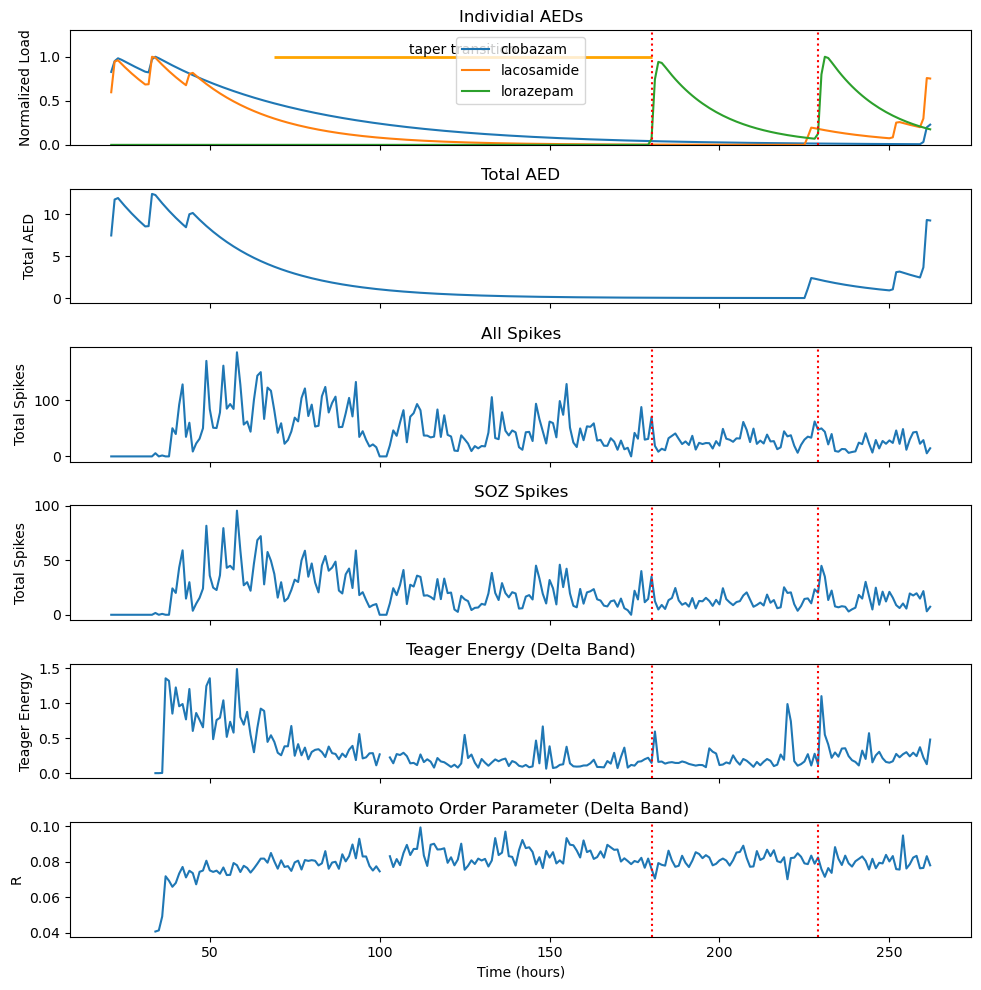

Processing hour 155
Processing electrode LA01
960
Processing electrode LA02
960
Processing electrode LA03
960
Processing electrode LA04
960
Processing electrode LA05
960
Processing electrode LA06
960
Processing electrode LA07
960
Processing electrode LA08
960
Processing electrode LA09
960
Processing electrode LA10
960
Processing electrode LA11
960
Processing electrode LA12
960
Processing electrode LB01
960
Processing electrode LB02
960
Processing electrode LB03
960
Processing electrode LB04
960
Processing electrode LB05
960
Processing electrode LB06
960
Processing electrode LB07
960
Processing electrode LB08
960
Processing electrode LB09
960
Processing electrode LB10
960
Processing electrode LB11
960
Processing electrode LB12
960
Processing electrode LC01
960
Processing electrode LC02
960
Processing electrode LC03
960
Processing electrode LC04
960
Processing electrode LC05
960
Processing electrode LC06
960
Processing electrode LC07
960
Processing electrode LC08
960
Processing electrode

In [9]:
# Frequency range of interest
freq_range = (60, 100)

for patient_hup_id in patient_hup_ids:
    print(f"Processing patient {patient_hup_id}")

    # Find the ieeg_start value for patient_hup_id in ieeg_starts_df and convert it into float
    ieeg_start_hrs = float(
        ieeg_starts_df.loc[
            ieeg_starts_df["hup_id"] == patient_hup_id, "ieeg_start"
        ].values[0]
    )
    aligned_emu_start_time_hrs = round(ieeg_start_hrs)

    # Initialize a DataFrame to store the results for this patient
    results_df = pd.DataFrame()

    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )
    taper_start, taper_end = find_taper_periods(hourly_patient_features_df)

    print(
        f"Patient {patient_hup_id} taper transition period: {taper_start} - {taper_end} = {taper_end - taper_start} hours"
    )
    plot_stuff(hourly_patient_features_df, taper_start, taper_end)

    # Get the row in datasets_df correspinding the patient_hup_id
    patient_datasets_df = datasets_df[datasets_df["hup_id"] == patient_hup_id]

    # Find the dataset_name and sample_rate for the first row in patient_datasets_df
    dataset_name = patient_datasets_df.iloc[0]["dataset_name"]
    sample_rate = patient_datasets_df.iloc[0]["sample_rate"]

    # Window size for FFT
    window_size = int(sample_rate * 0.125)  # 125 ms

    # Iterate hour from taper_start to taper_end
    for hour in range(170, 190):
        hour = hour - aligned_emu_start_time_hrs
        print(f"Processing hour {hour}")
        # Get the filename
        filename = f"{dataset_name}_hr_{hour}_fs_{sample_rate}.pkl"
        # Get the full path to the file
        full_path = os.path.join(IEEG_DIRECTORY, filename)

        # Load the data
        try:
            with open(full_path, "rb") as f:
                # print(f"Loading {filename}")
                eeg_segment_df = pickle.load(f)
        except FileNotFoundError:
            print(f"Skipping {hour} for {dataset_name}")
            continue

        channel_labels = eeg_segment_df.columns.values.tolist()
        channel_indices = np.arange(len(channel_labels))
        channel_types_df = check_channel_types(channel_labels)
        # Get a list of "name" in channel_types_df whose type is seeg
        seeg_channel_labels = channel_types_df[channel_types_df["type"] == "seeg"][
            "name"
        ].tolist()

        eeg_segment_df = eeg_segment_df[seeg_channel_labels]

        # Initialize a list to store the autocorrelations for each electrode
        autocorrelations = []

        # For each electrode
        for electrode in seeg_channel_labels:
            print(f"Processing electrode {electrode}")

            # Get the EEG signal for this electrode
            signal = eeg_segment_df[electrode]

            # Apply a notch filter at 60 Hz to remove line noise
            notch_b, notch_a = iirnotch(60, 30, sample_rate)
            signal = filtfilt(notch_b, notch_a, signal)

            # Calculate the power modulation
            power_modulation = []
            for i in range(0, len(signal), window_size):
                # Get the signal for this window
                window = signal[i : i + window_size]

                # Apply Hanning window
                window *= hanning(window_size)

                # Calculate FFT
                fft_result = fft(window)

                # Calculate power in the frequency range of interest
                power = np.abs(fft_result[freq_range[0] : freq_range[1]]) ** 2

                # # Normalize the power estimates by taking the logarithm
                # power = np.log(power)

                # Add the mean power to the power modulation
                power_modulation.append(np.nanmean(power))

            print(len(power_modulation))

            # Calculate the autocorrelation of the power modulation for lags from 0 to min(max_lag * sample_rate, len(power_modulation))
            autocorrelation = [
                np.correlate(
                    power_modulation[: -lag or None],
                    power_modulation[lag:],
                    mode="valid",
                )[0]
                for lag in range(len(power_modulation))
            ]

            # # Normalize the autocorrelation
            # autocorrelation /= max(autocorrelation)

            # Add the autocorrelation to the list
            autocorrelations.append(autocorrelation)

        # # Calculate ACW for each autocorrelation
        # acws = [calculate_acw(autocorrelation) for autocorrelation in autocorrelations]

        # # Calculate the average ACW
        # avg_acw = np.mean(acws)

        # Calculate the average autocorrelation for each lag across all electrodes
        avg_autocorrelation = np.nanmean(autocorrelations, axis=0)

        # Add the results to the DataFrame
        results_df = pd.concat(
            [
                results_df,
                pd.DataFrame(
                    [
                        {
                            "emu_hour": hour,
                            **{
                                f"lag_{i}": avg_autocorrelation[i]
                                for i in range(len(power_modulation))
                            },
                        }
                    ]
                ),
            ],
            ignore_index=True,
        )

    # Save the results to a CSV file
    results_df.to_csv(
        os.path.join(OUTPUT_DIRECTORY, f"HUP_{patient_hup_id}.csv"), index=False
    )

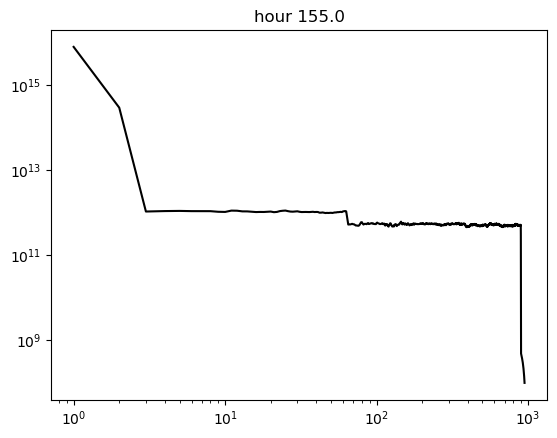

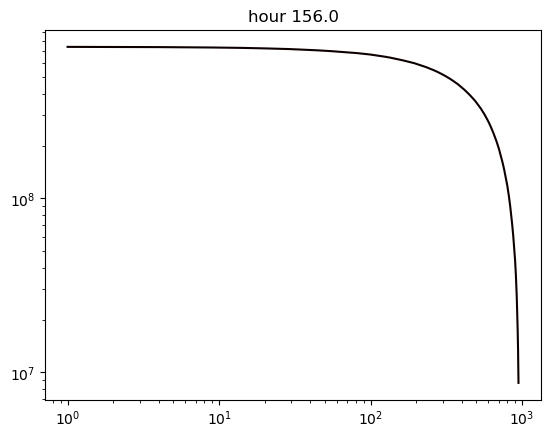

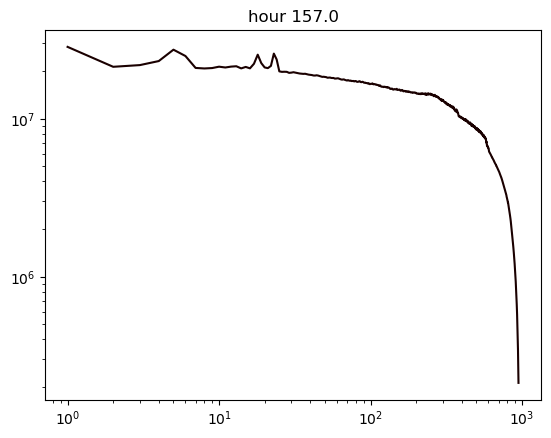

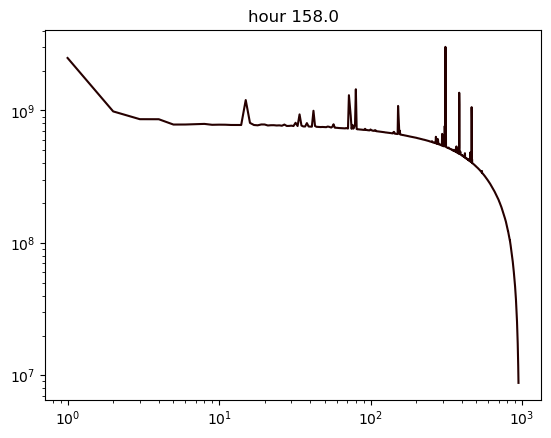

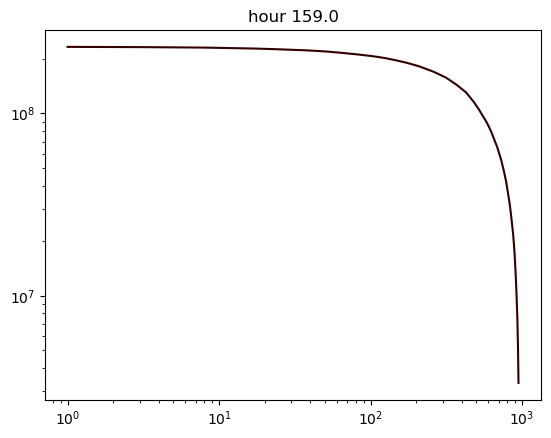

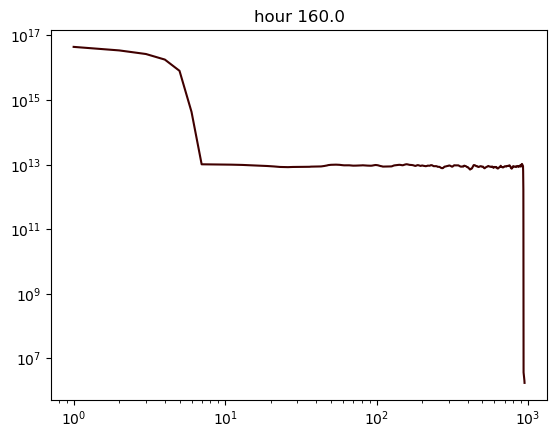

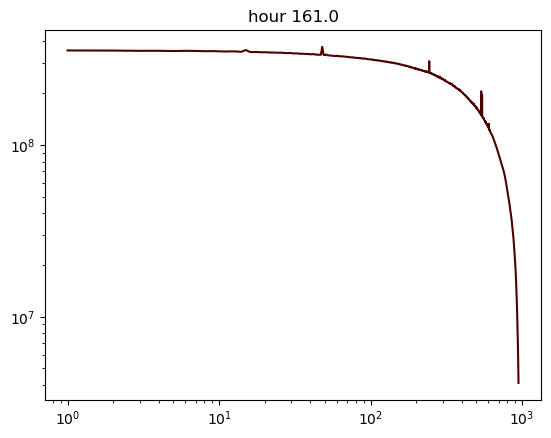

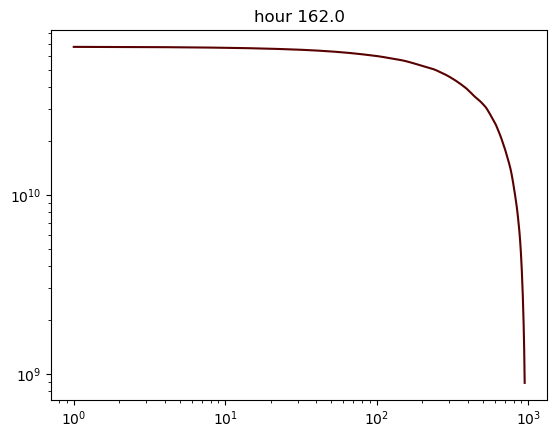

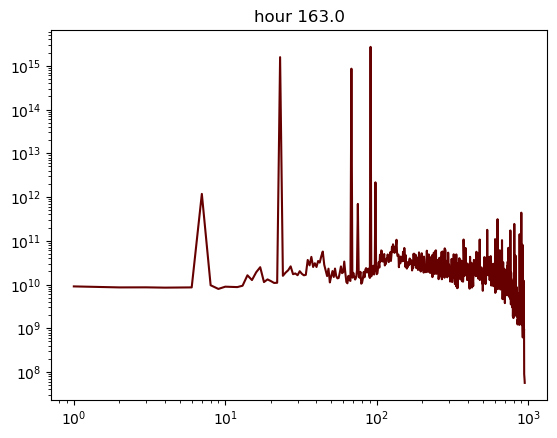

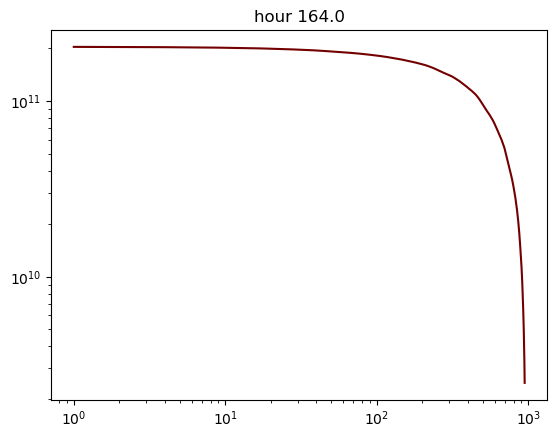

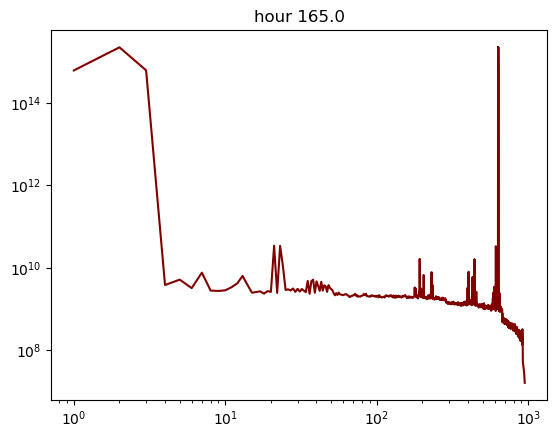

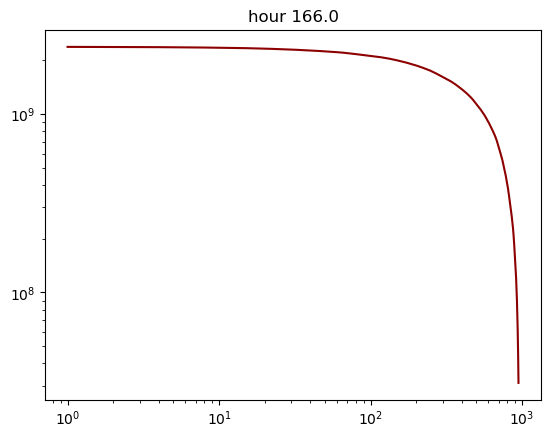

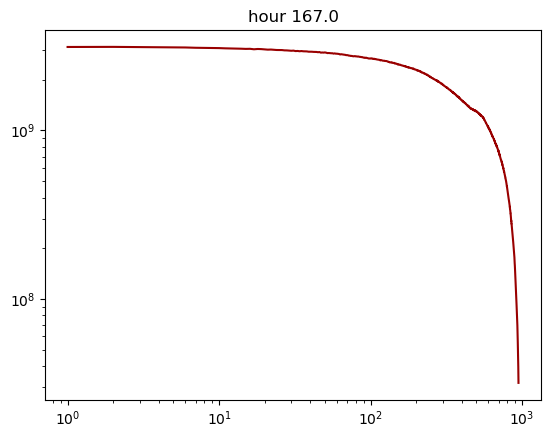

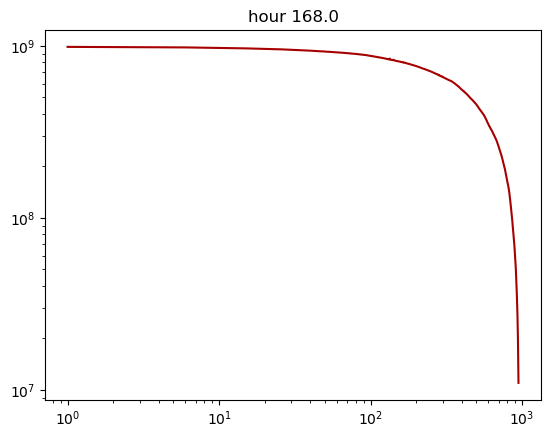

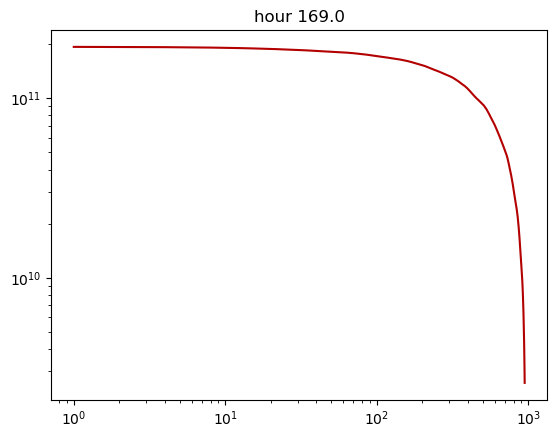

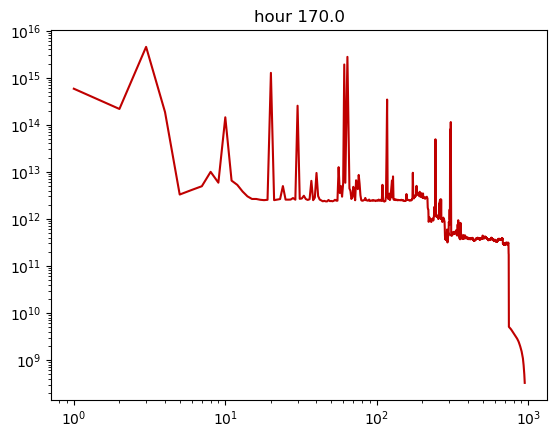

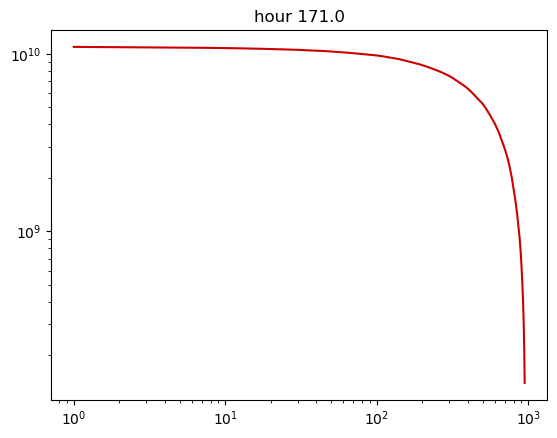

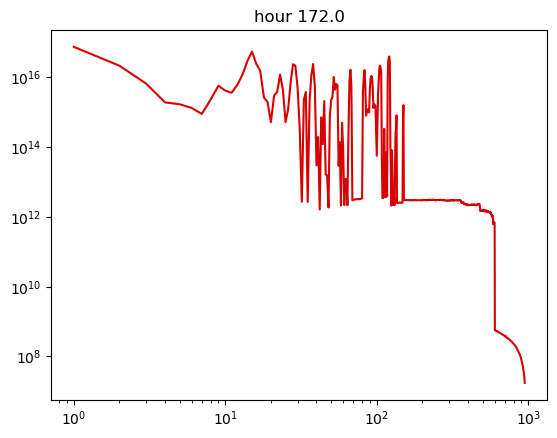

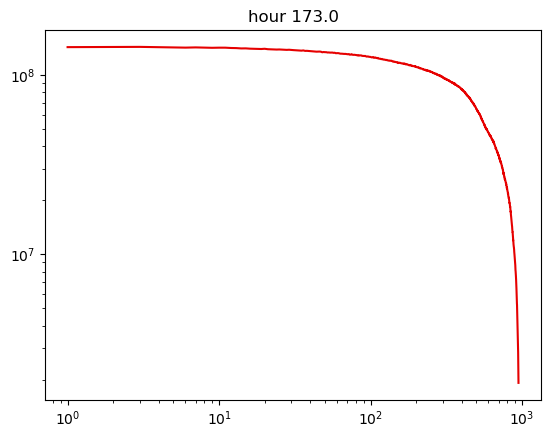

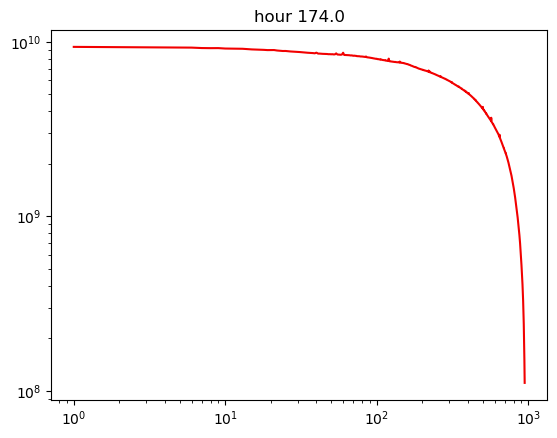

In [24]:
# Load HUP_210.csv from output directory
hup_210_df = pd.read_csv(os.path.join(OUTPUT_DIRECTORY, "HUP_210.csv"))

# For each row, calculate the first lag drops below of the first lag. Add that number as a column named acw
hup_210_df["acw_after"] = hup_210_df.apply(
    lambda row: np.argmax(row[1:] < row[1] * 0.4), axis=1
)

hup_210_df

# for each row, plot lag_0 to lag_19, all in the same plot
for index, row in hup_210_df.iterrows():
    # plt.plot(range(20), row[1:21]) but make it redder as index increases
    plt.loglog(range(1, 949), row[2:950], color=(index / len(hup_210_df), 0, 0))
    plt.title(f"hour {row.emu_hour}")
    plt.show()
# Make the curve with higher emu_hour redder

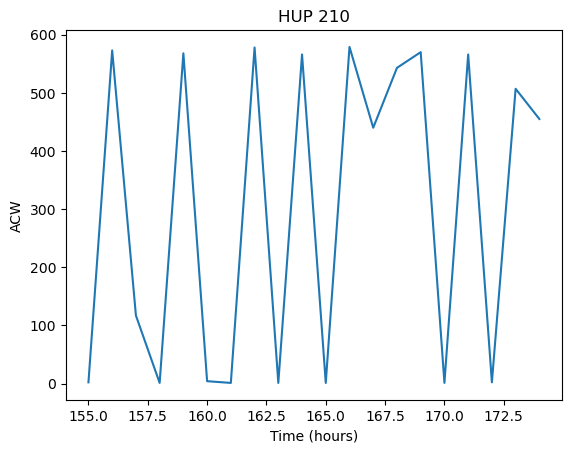

In [26]:
# Plot the awc column over time
plt.plot(hup_210_df["emu_hour"], hup_210_df["acw_after"])
plt.title("HUP 210")
plt.xlabel("Time (hours)")
plt.ylabel("ACW")
plt.show()

In [22]:
180 - aligned_emu_start_time_hrs

165